In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyod.models.pca import PCA
from pyod.utils.data import generate_data
from sklearn import metrics
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import plotly.graph_objects  as go
import seaborn as sns
sns.set_theme()

In [ ]:
def time_series_load_csv(filename:str, column_date:int=1, index_column:int=0, frequency:str='min', use_time:bool=True, date_index:bool=True, squeeze:bool=True, interpolate:bool=False) -> pd.DataFrame:
    time_series_df = pd.read_csv(filename, parse_dates=[column_date], index_col=index_column)
    
    date_format = '%Y-%m-%d %H:%M:%S' if use_time else '%Y-%m-%d'
    time_series_df['Date'] = pd.to_datetime(time_series_df['Date'], format=date_format)
    
    if date_index:
        time_series_df.set_index('Date', inplace=True)
        time_series_df = time_series_df.asfreq(frequency)
    
    if interpolate:
        time_series_df.interpolate(method='ffill', limit_direction='forward', inplace=True)
    
    if squeeze:
        return time_series_df.squeeze()
    else:
        return time_series_df

## Vervolg opdracht

In [175]:
df2 = time_series_load_csv(filename='freezerdata_clean_outliers.csv', use_time=True, frequency='min', squeeze=False, interpolate=False)
df2

,Door,EnergyKWh,Environment,HotGasPipe,LiquidPipe,Refrigerated,SuctionPipe,Time,Outlier
Date,,,,,,,,,
2023-03-14 23:00:00,0.0,100.0,NaN,NaN,NaN,NaN,NaN,0,0
2023-03-14 23:01:00,0.0,NaN,19.9,18.9,18.3,19.2,19.0,1,0
2023-03-14 23:02:00,0.0,NaN,19.9,18.9,18.5,19.4,19.1,2,0
2023-03-14 23:03:00,0.0,NaN,19.9,18.9,18.4,19.2,18.9,3,0
2023-03-14 23:04:00,0.0,NaN,19.9,18.9,18.4,19.3,19.0,4,0
...,...,...,...,...,...,...,...,...,...
2023-03-19 18:56:00,0.0,NaN,NaN,30.1,27.1,-3.5,NaN,6956,0
2023-03-19 18:57:00,0.0,NaN,21.4,39.7,29.2,-2.2,7.0,6957,0
2023-03-19 18:58:00,0.0,NaN,21.5,40.9,28.7,-2.0,6.4,6958,0


In [ ]:
def calculate_peaks_and_valleys(dataframe:pd.DataFrame, column:str, peak_height:float, valley_height:float, distance:float) -> pd.DataFrame:
    array = dataframe[column].to_numpy()
    
    peaks, _ = find_peaks(array, height=peak_height, distance=distance)
    valleys, _ = find_peaks(-array, height=valley_height, distance=distance)
    
    peaks_valleys_df = pd.DataFrame({
        'Index': np.concatenate([peaks, valleys]),
        'Value': np.concatenate([array[peaks], array[valleys]]),
        'Type': ['Peak'] * len(peaks) + ['Valley'] * len(valleys)
    }).reset_index(drop=True)
    
    return peaks_valleys_df

In [ ]:
def identify_outliers(dataframe:pd.DataFrame, column:str, peaks_valleys_df:pd.DataFrame) -> tuple[DataFrame, float, float]:

    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    peaks_valleys_df['Is_Outlier'] = peaks_valleys_df['Value'].apply(
        lambda x: x < lower_bound or x > upper_bound
    )
    
    return peaks_valleys_df, upper_bound, lower_bound

In [176]:
peaks_valleys = calculate_peaks_and_valleys(dataframe=df2, column='Refrigerated', peak_height=3, valley_height=4, distance=1)
peaks_valleys

,Index,Value,Type
0,2,19.4,Peak
1,5,19.4,Peak
2,9,19.3,Peak
3,12,19.3,Peak
4,16,19.4,Peak
...,...,...,...
313,6546,-5.7,Valley
314,6690,-5.1,Valley
315,6787,-4.1,Valley
316,6800,-5.3,Valley


In [177]:
peaks_valleys_with_outliers = identify_outliers(df2, column='Refrigerated', peaks_valleys_df=peaks_valleys)[0]
peaks_valleys_with_outliers

,Index,Value,Type,Is_Outlier
0,2,19.4,Peak,True
1,5,19.4,Peak,True
2,9,19.3,Peak,True
3,12,19.3,Peak,True
4,16,19.4,Peak,True
...,...,...,...,...
313,6546,-5.7,Valley,True
314,6690,-5.1,Valley,True
315,6787,-4.1,Valley,False
316,6800,-5.3,Valley,True


In [178]:
outliers = peaks_valleys_with_outliers[peaks_valleys_with_outliers['Is_Outlier']]
non_outliers = peaks_valleys_with_outliers[~peaks_valleys_with_outliers['Is_Outlier']]

In [179]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df2['Time'],
    y=df2['Refrigerated'],
    mode='lines',
    name='Refrigerated values',
    marker=dict(color='black')
))

fig.add_trace(go.Scatter(
    x=non_outliers['Index'],
    y=non_outliers['Value'],
    mode='markers',
    marker=dict(color='#00CC96', size=10, symbol='circle'),
    name='Non-Outlier'
))

fig.add_trace(go.Scatter(
    x=outliers['Index'],
    y=outliers['Value'],
    mode='markers',
    marker=dict(color='#636EFA', size=10, symbol='x'),
    name='Outlier'
))

fig.add_hline(
    y=identify_outliers(df2, column='Refrigerated', peaks_valleys_df=peaks_valleys)[1],
    line_dash='dot',
    line_color='red',
    annotation_text='Upper Limit',
    annotation_position='top right',
    annotation=dict(font=dict(color='red', size=15, family='Arial', weight='bold'))
)

fig.add_hline(
    y=identify_outliers(df2, column='Refrigerated', peaks_valleys_df=peaks_valleys)[2],
    line_dash='dot',
    line_color='red',
    annotation_text='Lower Limit',
    annotation_position='bottom right',
    annotation=dict(font=dict(color='red', size=15, family='Arial', weight='bold'))
)

fig.update_layout(
    xaxis=dict(
        title='Time',
        range=[1000, df2['Time'].max()]  
    ),
    yaxis=dict(
        title='Temperature [°C]',
        range=[-8, 12]
    ),
    title='Peaks and Valleys with Outliers Highlighted',
    legend=dict(title='Legend'),
    template="plotly"
)

fig.show()

In [180]:
true_outlier_points = df2[df2['Outlier'] == 1]
pred_outlier_points = outliers['Is_Outlier']

In [181]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df2['Time'],
    y=df2['Refrigerated'],
    mode='lines',
    name='Refrigerated values'
))

fig.add_trace(go.Scatter(
    x=true_outlier_points['Time'],
    y=true_outlier_points['Refrigerated'],
    mode='markers',
    name='Outliers',
    marker=dict(
        color='red', 
        size=10, 
        symbol='x'
    )
))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Temperature [°C]',
    title='Pre-defined outliers plotted',
    legend=dict(title='Legend'),
    template="plotly"
)

fig.show()

In [182]:
confusion_matrix = metrics.confusion_matrix(true_outlier_points['Refrigerated'], outliers['Is_Outlier'])

ValueError: Found input variables with inconsistent numbers of samples: [101, 292]

# Opdracht volgende les

### Outlier detection with generated data

In [126]:
def pca_data_prep(dataframe:pd.DataFrame, columns:list[str], outlier_colum:str, start:int, end:int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_train_pd = dataframe.loc[:, columns].diff()
    X_train_pd.dropna(inplace=True)
    X_train = X_train_pd.to_numpy()
    
    y_train = dataframe.loc[:, outlier_colum] 
    
    X_test_pd = X_train_pd.copy()[start:end]
    X_test = X_test_pd.to_numpy()
    
    return X_train, y_train, X_test

In [127]:
def pca_outlier_detection(data:np.array, contamination:float, params:bool=False, fit:bool=False) \
        -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_train = data[0]
    X_test = data[2]
    pca = PCA(contamination=contamination)
    fit_value = pca.fit(X_train)
    
    y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
    y_train_scores = pca.decision_function(X_train) # You also can use .decision_function()
    y_train_pred = pca.predict(X_train) # You also can use .decision_function()
    y_test_scores = pca.decision_function(X_test) # You also can use .decision_function()
    y_test_pred = pca.predict(X_test) # You also can use .decision_function()
    
    if params:
        return pca.get_params()

    if fit:
        return fit_value
    
    return y_train_pred, y_train_scores, y_train_pred, y_test_scores, y_test_pred, pca.threshold_

In [128]:
def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df.columns = feature_list
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold,
                 'Normal', 'Outlier')
    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    # The count and count %
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
    # The average
    stat = df.groupby('Group').mean().round(2).reset_index()
    # Put the count and the average together
    stat = cnt.merge(stat, left_on='Group', right_on='Group')
    return stat

In [129]:
def confusion_matrix_threshold(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return cm

In [130]:
X_train, X_test, y_train, y_test = generate_data(
    n_train=5000,
    n_test=1000,
    n_features= 2,
    contamination=0.05,
    random_state=123)

In [131]:
X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)

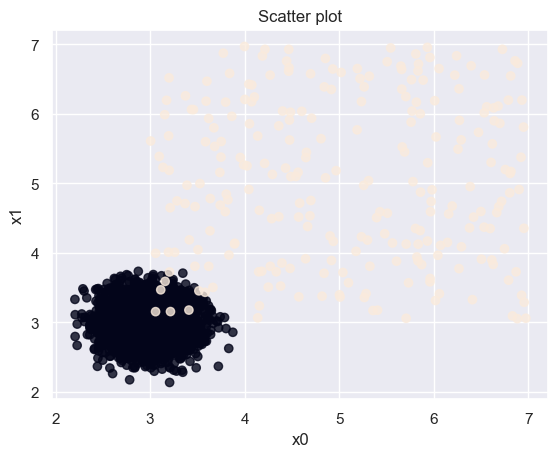

In [132]:
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [133]:
pca = PCA(contamination=0.05)
pca.fit(X_train)

PCA(contamination=0.05, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [134]:
y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
y_train_scores = pca.decision_function(X_train) # You also can use .decision_function()
y_train_pred = pca.predict(X_train) # You also can use .decision_function()
y_test_scores = pca.decision_function(X_test) # You also can use .decision_function()
y_test_pred = pca.predict(X_test) # You also can use .decision_function()

In [135]:
pca.get_params()

{'contamination': 0.05,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [136]:
print("The threshold for the defined contamination rate:" , pca.threshold_)

The threshold for the defined contamination rate: 14.25636444016148


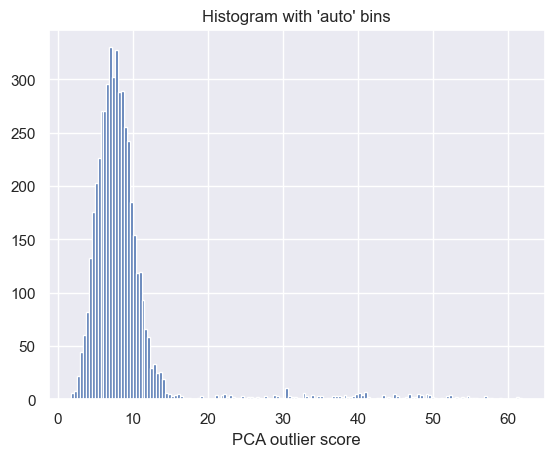

In [137]:
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

In [138]:
feature_list = ['Feature_1','Feature_2']
descriptive_stat_threshold(X_train, y_train_scores, pca.threshold_)

,Group,Count,Count %,Feature_1,Feature_2,Anomaly_Score
0,Normal,4750,95.0,3.00,3.00,7.70
1,Outlier,250,5.0,4.96,5.02,35.51


In [139]:
confusion_matrix_threshold(y_test,y_test_scores,pca.threshold_)

Pred,0,1
Actual,,
0.0,947,3
1.0,4,46


### Outlier detection with freezer_clean data

In [163]:
df3 = time_series_load_csv(filename='freezerdata_clean_outliers.csv', use_time=True, squeeze=False, interpolate=True, date_index=False)
df3

,Date,Door,EnergyKWh,Environment,HotGasPipe,LiquidPipe,Refrigerated,SuctionPipe,Time,Outlier
0,2023-03-14 23:00:00,0.0,100.0,NaN,NaN,NaN,NaN,NaN,0,0
1,2023-03-14 23:01:00,0.0,100.0,19.9,18.9,18.3,19.2,19.0,1,0
2,2023-03-14 23:02:00,0.0,100.0,19.9,18.9,18.5,19.4,19.1,2,0
3,2023-03-14 23:03:00,0.0,100.0,19.9,18.9,18.4,19.2,18.9,3,0
4,2023-03-14 23:04:00,0.0,100.0,19.9,18.9,18.4,19.3,19.0,4,0
...,...,...,...,...,...,...,...,...,...,...
6956,2023-03-19 18:56:00,0.0,700.0,21.3,30.1,27.1,-3.5,13.1,6956,0
6957,2023-03-19 18:57:00,0.0,700.0,21.4,39.7,29.2,-2.2,7.0,6957,0
6958,2023-03-19 18:58:00,0.0,700.0,21.5,40.9,28.7,-2.0,6.4,6958,0
6959,2023-03-19 18:59:00,0.0,700.0,21.6,38.6,27.8,-1.6,7.2,6959,0


In [164]:
columns = ['Door', 'EnergyKWh', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']
pca_data = pca_data_prep(dataframe=df3, columns=columns, outlier_colum='Outlier', start=2000, end=2500)

In [165]:
pca_outliers = pca_outlier_detection(pca_data, contamination=0.05)

In [166]:
pca_outlier_detection(pca_data, contamination=0.05)[0]

array([0, 0, 0, ..., 0, 0, 0])

In [168]:
df3 = df3.iloc[2:].copy()
df3['PCA Predicted Outliers'] = pca_outlier_detection(pca_data, contamination=0.01)[0]
df3['PCA Predicted Outliers']

2       0
3       0
4       0
5       0
6       0
       ..
6956    0
6957    0
6958    0
6959    0
6960    0
Name: PCA Predicted Outliers, Length: 6959, dtype: int32

In [169]:
print("The threshold for the defined contamination rate:" , pca_outliers[5])

The threshold for the defined contamination rate: 916.5033683481186


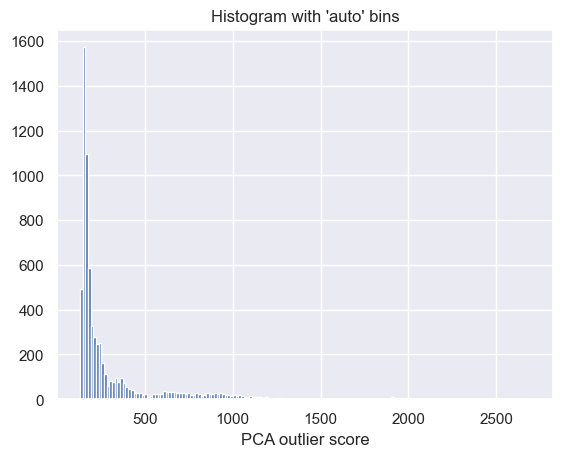

In [170]:
plt.hist(pca_outliers[1], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

In [171]:
confusion_matrix_threshold(pca_outliers[4], pca_outliers[3], pca_outliers[5])

Pred,0,1
Actual,,
0,474,0
1,0,26


In [174]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df3['Time'],
    y=df3['Refrigerated'],
    mode='lines',
    name='Refrigerated values',
    marker=dict(color='black')
))

fig.add_trace(go.Scatter(
    x=df3['Time'],
    y=df3[df3['Outlier'] == df3['PCA Predicted Outliers']],
    marker=dict(color='red'),
    name='Correct outliers',
    mode='markers'
))

fig.add_trace(go.Scatter(
    x=df3['Time'],
    y=df3[df3['Outlier'] != df3['PCA Predicted Outliers']],
    marker=dict(color='blue'),
    name='Incorrect outliers',
    mode='markers'
))

fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Temperature [°C]',
    title='Pre-defined outliers plotted',
    legend=dict(title='Legend'),
    template="plotly"
)

fig.show()